In [1]:
import numpy as np
import sys
from casadi import *

import do_mpc
import warnings
warnings.filterwarnings("ignore")

In [2]:
model_type = 'continuous' 
model = do_mpc.model.Model(model_type)

In [3]:
x_ego = model.set_variable('_x',  'x_ego')
v_ego = model.set_variable('_x',  'v_ego')

x_lead = model.set_variable('_x',  'x_lead')
v_lead = model.set_variable('_x',  'v_lead')

a_ego = model.set_variable('_u',  'a_ego')
a_lead = model.set_variable('_tvp',  'a_lead')

In [4]:
model.set_rhs('x_ego', v_ego)
model.set_rhs('v_ego', a_ego)
model.set_rhs('x_lead', v_lead)
model.set_rhs('v_lead', a_lead)

In [5]:
t_gap=model.set_expression('t_gap', SX(1.4))
D_default=model.set_expression('D_default', SX(10))
D_safe=model.set_expression('D_safe', D_default+t_gap*v_ego)
v_set=model.set_expression('v_set', SX(30))
D_relative=model.set_expression('D_relative', x_lead-x_ego)

In [6]:
model.setup()

In [7]:
Ts=0.1
T=80
PredictionHorizon=10

In [8]:
simulator = do_mpc.simulator.Simulator(model)

In [9]:
tvp_template_sim = simulator.get_tvp_template()

**Motion of lead vehicle is defined by a sinusoidal acceleration profile**

In [10]:
def tvp_fun_sim(t_now):
    tvp_template_sim['a_lead'] = np.sin(2*np.pi*(1/30)*t_now)
    return tvp_template_sim

In [11]:
simulator.set_tvp_fun(tvp_fun_sim)

In [12]:
params_simulator = {
    'integration_tool': 'idas',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': Ts
}

simulator.set_param(**params_simulator)

In [13]:
simulator.setup()

In [14]:
simulator.x0['x_ego']=10
simulator.x0['v_ego']=20
simulator.x0['x_lead']=50
simulator.x0['v_lead']=25
x0 = simulator.x0.cat.full()
simulator.set_initial_guess()

In [15]:
mpc = do_mpc.controller.MPC(model)

In [16]:
setup_mpc = {
    'n_horizon': PredictionHorizon,
    'n_robust': 0,
    'open_loop': 0,
    't_step': Ts,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [17]:
tvp_template_mpc=mpc.get_tvp_template()

In [18]:
def tvp_fun_mpc(t_now):
    for k in range(PredictionHorizon+1):
        tvp_template_mpc['_tvp',k,'a_lead']=np.sin(2*np.pi*(1/30)*t_now)
    return tvp_template_mpc

In [19]:
mpc.set_tvp_fun(tvp_fun_mpc)

**Objective of optimization is to keep safe distance. Velocity is controlled by setting a constraint on upper bound for velocity**

In [20]:
mterm =(model.aux['D_relative']-model.aux['D_safe'])**2
lterm=mterm
mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(a_ego=0.1)

In [21]:
mpc.set_nl_cons('velocity', v_ego, 30)

SX(v_ego)

In [22]:
mpc.bounds['lower','_u','a_ego'] = -3
mpc.bounds['upper','_u','a_ego'] = 2

In [23]:
mpc.setup()

In [24]:
estimator = do_mpc.estimator.StateFeedback(model)

In [25]:
mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [26]:
%%capture
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams['font.size'] = 14
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True


mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(3, sharex=True, figsize=(12, 9)) 


for g in [sim_graphics, mpc_graphics]:
    g.add_line(var_type='_u', var_name='a_ego', axis=ax[0])
    g.add_line(var_type='_tvp', var_name='a_lead', axis=ax[0])
    g.add_line(var_type='_x', var_name='v_ego', axis=ax[1])
    g.add_line(var_type='_x', var_name='v_lead', axis=ax[1])
    g.add_line(var_type='_aux', var_name='v_set', axis=ax[1])
    g.add_line(var_type='_aux', var_name='D_relative', axis=ax[2]) 
    g.add_line(var_type='_aux', var_name='D_safe', axis=ax[2]) 

for g in [sim_graphics]:
    label_lines = g.result_lines['_u', 'a_ego']+g.result_lines['_tvp', 'a_lead']
    ax[0].legend(label_lines, ['ego', 'lead'])
    label_lines = g.result_lines['_x', 'v_ego']+g.result_lines['_x', 'v_lead']
    ax[1].legend(label_lines, ['ego', 'lead','set'])
    label_lines = g.result_lines['_aux', 'D_relative']+g.result_lines['_aux', 'D_safe']
    ax[2].legend(label_lines, ['actual', 'safe'])

ax[0].set_ylabel('$m/s^2$ (m)')
ax[1].set_ylabel('m/s')
ax[2].set_ylabel('m')
ax[2].set_xlabel('Time (s)')


ax[0].set_title('Acceleration')
ax[1].set_title('Velocity')
ax[2].set_title('Distance between two cars')


fig.align_ylabels()


plt.tight_layout()


plt.show()

In [27]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      734
Number of nonzeros in inequality constraint Jacobian.:       10
Number of nonzeros in Lagrangian Hessian.............:       85

Total number of variables............................:      230
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:      204
Total number of inequality c

In [28]:
sim_graphics.clear()

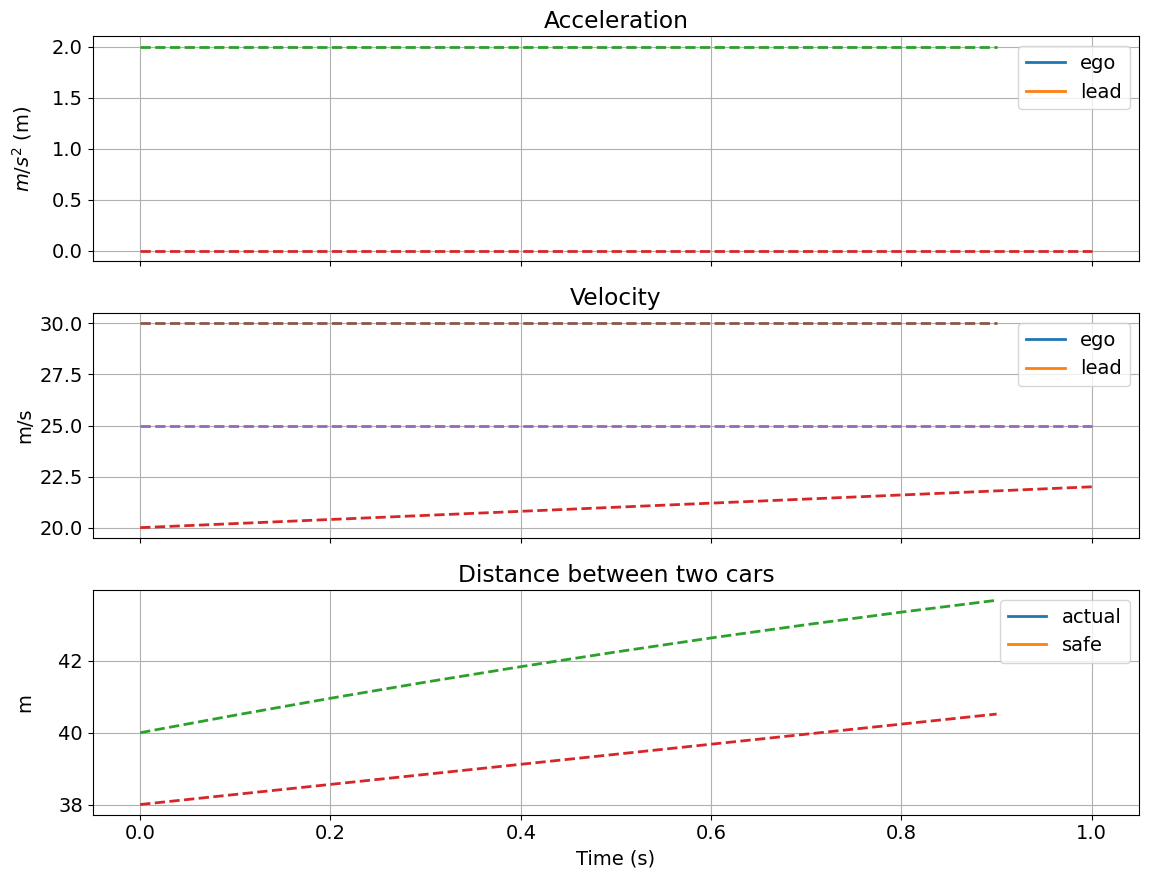

In [29]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [30]:
%%capture
# Quickly reset the history of the MPC data object.
import time
start_time = time.time()

mpc.reset_history()
simulator.reset_history()

for k in range(T*10):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
end_time = time.time()

In [31]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 7.271886825561523 seconds


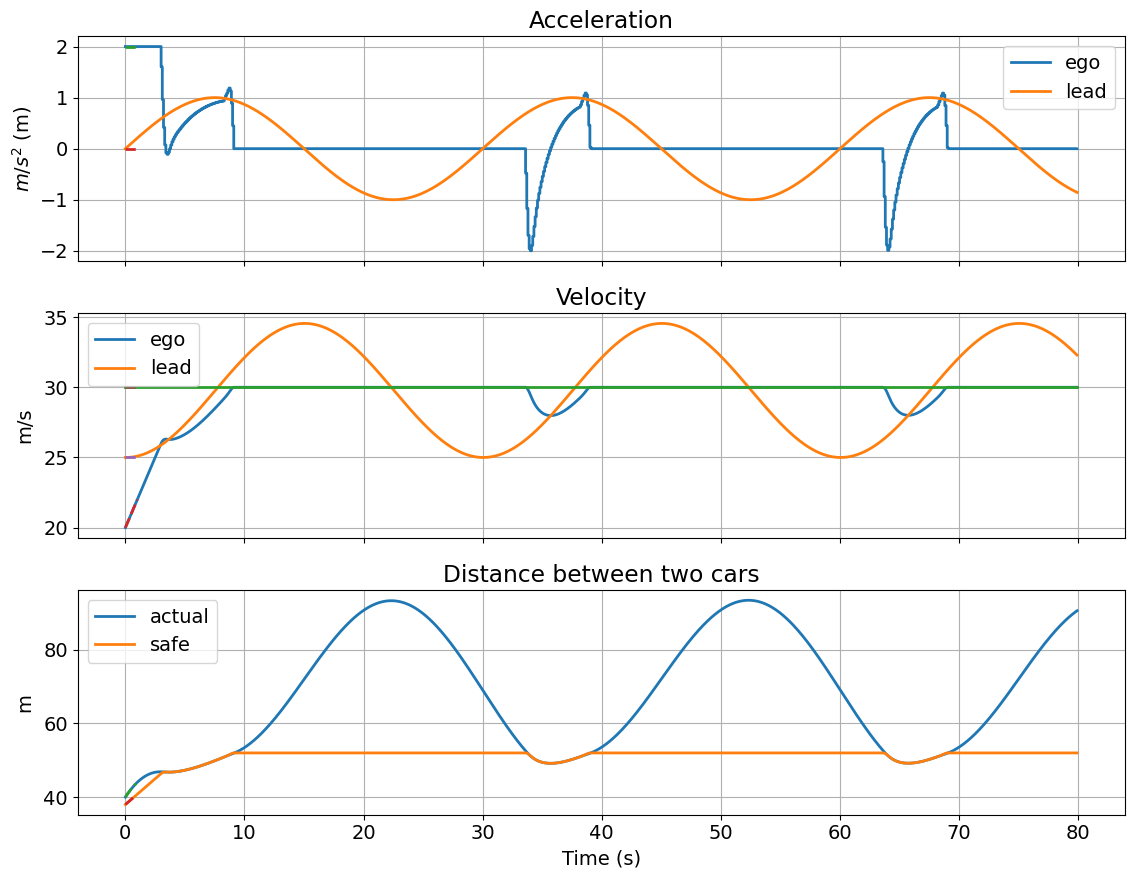

In [32]:
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

**Results**
- As can be seen from the plots above. The controller makes sure that the actual distance between the vehicles is greater than the set safe distance.
- When the safe distance is large enough the ego vehicle accelerates and follows the set velocity.
- When the actual distance and safe distance are close the ego vehicle decelerates and keeps the safe distance till the safe distance starts to increase. 